# Digital Economy + commoncrawl

This notebook will include tasks related to linking the digital economy project and the current commoncrawl output.

Big questions:
- Which (New Zealand) companies have a digital presence?
- Understanding traffic/sales to each company/website.
- Is a digital equivalent to the sales information collected by the CPI surveys possible?

In [1]:
import os, sys
import re
import csv, json
import random
import itertools
import boto3
from urllib import parse
from collections import Counter

import numpy as np
import pandas as pd
from pandarallel import pandarallel
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import gensim

In [2]:
pandarallel.initialize(progress_bar=True)
sess = boto3.Session(profile_name="xmiles")

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
def read_csv_from_s3(bucket, key):
    s3_client = sess.client('s3')
    resp = s3_client.get_object(Bucket=bucket, Key=key)
    # Python 3.8/3.9 can't download files over 2GB via HTTP, so file is 
    # streamed just in case
    csv_str = b''.join([
        chunk for chunk in resp['Body'].iter_chunks()
    ]).decode()
    
    # keepends=True to preserve newlines within Text fields
    csv_lines = csv_str.splitlines(keepends=True)
    csv_list = list(csv.reader(csv_lines, quotechar='"'))
    df = pd.DataFrame(csv_list[1:], columns=csv_list[0])
    
    return df

## Which websites are there?

Extracting unique websites from the commoncrawl output.

In [5]:
%%time
s3 = sess.client('s3')
output_keys = [
    x['Key'] for x in
    s3.list_objects_v2(Bucket="statsnz-covid-xmiles", Prefix="commoncrawl/processed_ccmain_bunches/CC-MAIN-2021-10/")['Contents']
]
all_output = pd.concat((
    read_csv_from_s3("statsnz-covid-xmiles", key) for key in output_keys
))
print(f"Number of rows: {all_output.shape[0]} (from {len(output_keys)} CSVs)")

# Number of rows: 1,676,767 (from 215 CSVs)
# CPU times: user 53 s, sys: 7.33 s, total: 1min
# Wall time: 1min 46s

Number of rows: 1676767 (from 215 CSVs)
CPU times: user 58.3 s, sys: 7.22 s, total: 1min 5s
Wall time: 2min 2s


In [6]:
all_output.head()

,Datetime,URL,Text
0,2021-03-05T13:19:47.000Z,http://0800treetrim.nz/,Trees And First Impressions When it comes to R...
1,2021-03-05T12:38:51.000Z,http://0800treetrim.nz/author/treeguys/,Tree Care And Tree Selection\n\nTree Care star...
2,2021-03-05T12:52:16.000Z,http://0800treetrim.nz/category/treework/,Tree Care And Tree Selection\n\nTree Care star...
3,2021-03-05T13:08:37.000Z,http://0800treetrim.nz/coming-soon/,Site under construction.\n\nNew tree service c...
4,2021-03-05T14:15:11.000Z,http://0800treetrim.nz/faqs/,Why 0800 Tree Trim Ltd is topping the competit...


In [7]:
def get_netloc(url):
    return parse.urlsplit(url).netloc

In [8]:
all_output['netloc'] = all_output['URL'].map(get_netloc)
all_output.head()

,Datetime,URL,Text,netloc
0,2021-03-05T13:19:47.000Z,http://0800treetrim.nz/,Trees And First Impressions When it comes to R...,0800treetrim.nz
1,2021-03-05T12:38:51.000Z,http://0800treetrim.nz/author/treeguys/,Tree Care And Tree Selection\n\nTree Care star...,0800treetrim.nz
2,2021-03-05T12:52:16.000Z,http://0800treetrim.nz/category/treework/,Tree Care And Tree Selection\n\nTree Care star...,0800treetrim.nz
3,2021-03-05T13:08:37.000Z,http://0800treetrim.nz/coming-soon/,Site under construction.\n\nNew tree service c...,0800treetrim.nz
4,2021-03-05T14:15:11.000Z,http://0800treetrim.nz/faqs/,Why 0800 Tree Trim Ltd is topping the competit...,0800treetrim.nz


In [9]:
unique_netlocs = set(all_output['netloc'])
print(f"There is {len(unique_netlocs)} unique netlocs from {len(all_output)} URLs")

There is 41166 unique netlocs from 1676767 URLs


Save all the unique netlocs to .txt file. 

Is a netloc/network location equivalent to a website? Yes

In [10]:
output_keys_simple = [key.split('/')[-1] for key in output_keys]
txt_str = f"CC-MAIN-2021-10 New Zealand\n" + \
          f"Included bunches: {','.join(output_keys_simple)}\n\n" + \
           "\n".join(sorted(unique_netlocs)) + "\n"

with open("ccmain-2021-10-nz-netlocs.txt", 'w') as f:
    f.write(txt_str)

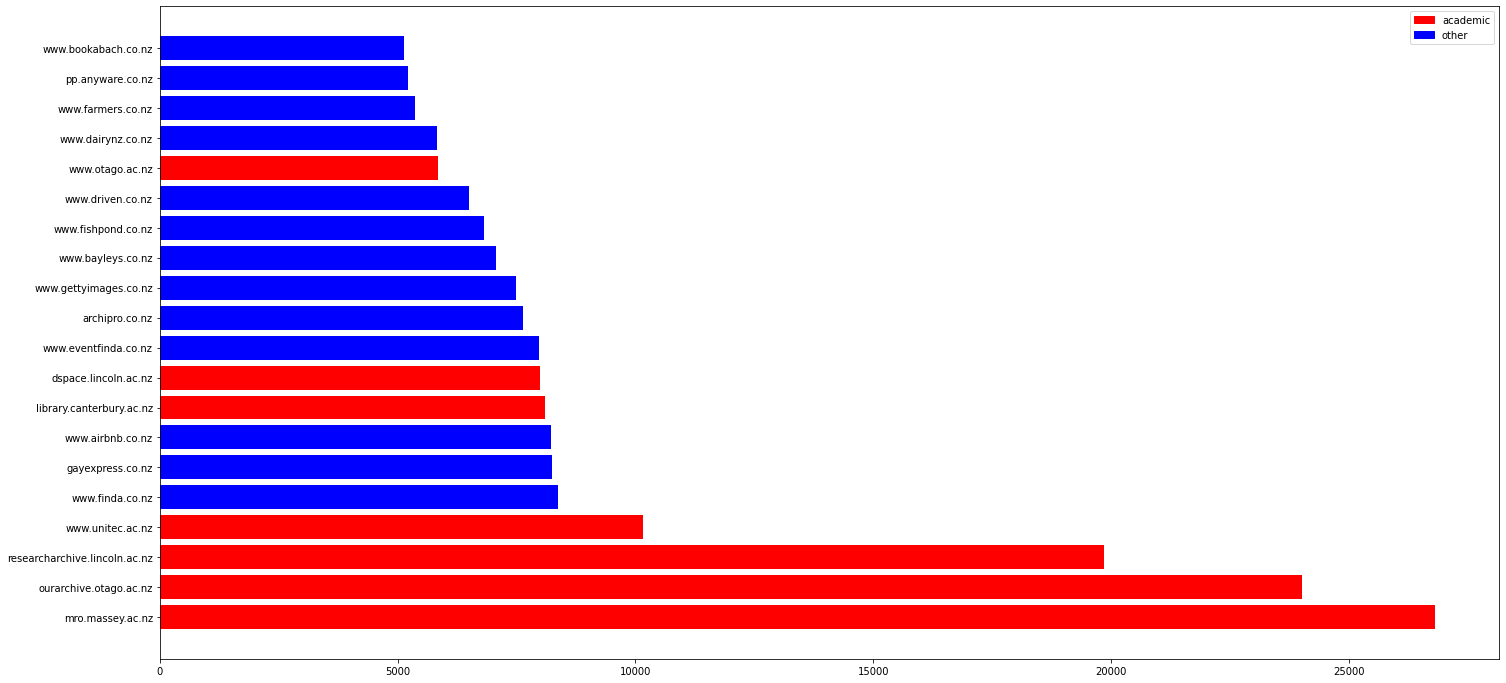

In [11]:
netloc_counter = Counter(all_output['netloc'])
top_netloc = netloc_counter.most_common(20)

top_netloc_names = [x[0] for x in top_netloc]
y_pos = range(len(top_netloc_names))
top_netloc_nums = [x[1] for x in top_netloc]
cols = ["red" if name.endswith(".ac.nz") else "blue" 
        for name in top_netloc_names]

colors = {'academic':'red', 'other':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

fig, ax = plt.subplots(figsize=(24, 12))
ax.barh(y_pos, top_netloc_nums, color=cols)
ax.legend(handles, labels)
ax.set(yticks=y_pos, yticklabels=top_netloc_names);

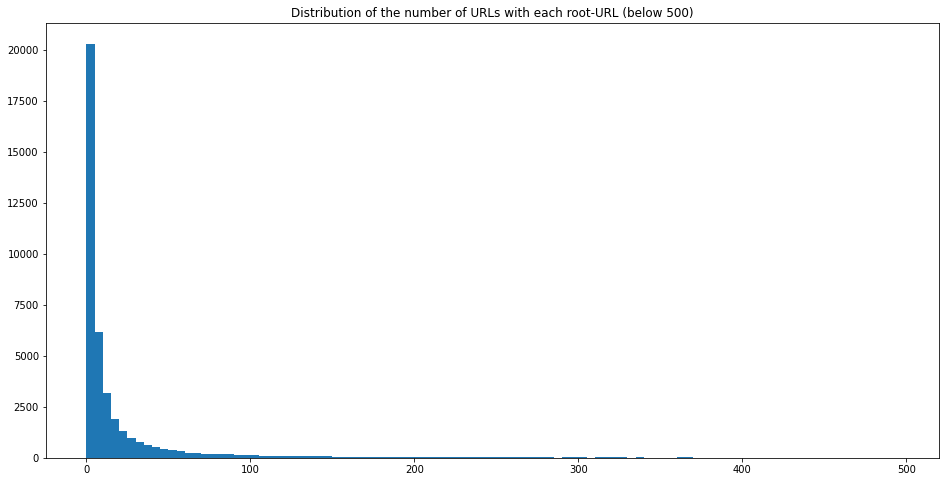

In [12]:
netloc_sorted = netloc_counter.most_common(len(netloc_counter))

netloc_nums = [x[1] for x in netloc_sorted
               if x[1] < 500]
bins = range(0, 500, 5)

fig, ax = plt.subplots(figsize=(16, 8))
ax.hist(netloc_nums, bins=bins)
ax.set(title="Distribution of the number of URLs with each root-URL (below 500)");

## Is there any duplicate websites within the same batch?

In [13]:
all_output[all_output['URL'].duplicated(keep=False)]

,Datetime,URL,Text,netloc
75,2021-02-25T04:11:45.000Z,http://150yearspolesdownsouth.nz/,Toward the end of the 18th century the Polish-...,150yearspolesdownsouth.nz
76,2021-03-02T11:14:01.000Z,http://150yearspolesdownsouth.nz/,Toward the end of the 18th century the Polish-...,150yearspolesdownsouth.nz
214,2021-02-25T15:53:34.000Z,https://git.1j.nz/jason,declutter 0 0\n\nRemoves the clutter from vari...,git.1j.nz
215,2021-03-08T02:45:29.000Z,https://git.1j.nz/jason,declutter 0 0\n\nRemoves the clutter from vari...,git.1j.nz
220,2021-02-25T17:04:44.000Z,https://git.1j.nz/jason/declutter/src/master/p...,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,git.1j.nz
...,...,...,...,...
4064,2021-03-02T05:14:30.000Z,https://www.keithandrews.co.nz/mercedes-benz,Keith Andrews has the full range of Mercedes-B...,www.keithandrews.co.nz
4072,2021-02-26T00:58:24.000Z,https://www.keithandrews.co.nz/mercedes-benz/p...,"Used Mercedes-Benz Trucks, Buses and Vans for ...",www.keithandrews.co.nz
4073,2021-03-05T03:45:53.000Z,https://www.keithandrews.co.nz/mercedes-benz/p...,"Used Mercedes-Benz Trucks, Buses and Vans for ...",www.keithandrews.co.nz
4795,2021-02-24T20:40:12.000Z,https://kellifromthetron.co.nz/2016/05/03/hami...,Since finishing school and leaving home which ...,kellifromthetron.co.nz


In [14]:
all_duplicate_url_rows = sum(all_output['URL'].duplicated(keep=False))
num_duplicate_url_rows = sum(all_output['URL'].duplicated())

print(f"{all_duplicate_url_rows} of the rows have a duplicate URL")
print(f"With duplicate URLs removed, there would be {num_duplicate_url_rows} fewer rows")
print(f"(Total number of rows: {all_output.shape[0]})")

32569 of the rows have a duplicate URL
With duplicate URLs removed, there would be 23662 fewer rows
(Total number of rows: 1676767)


In [15]:
all_output[all_output['Text'].duplicated(keep=False)]

,Datetime,URL,Text,netloc
1,2021-03-05T12:38:51.000Z,http://0800treetrim.nz/author/treeguys/,Tree Care And Tree Selection\n\nTree Care star...,0800treetrim.nz
2,2021-03-05T12:52:16.000Z,http://0800treetrim.nz/category/treework/,Tree Care And Tree Selection\n\nTree Care star...,0800treetrim.nz
7,2021-03-05T12:34:30.000Z,http://0800treetrim.nz/tag/add-value-to-a-prop...,Trees And First Impressions\n\nWhen it comes t...,0800treetrim.nz
8,2021-03-05T12:56:29.000Z,http://0800treetrim.nz/tag/cheap-tree-removal/,Why use professional tree specialists to remov...,0800treetrim.nz
9,2021-03-05T13:48:20.000Z,http://0800treetrim.nz/tag/choosing-the-right-...,Tree Care And Tree Selection\n\nTree Care star...,0800treetrim.nz
...,...,...,...,...
5576,2021-02-27T00:55:40.000Z,https://kellysports.co.nz/south-waitakere,Please enter either a location or a school zon...,kellysports.co.nz
5577,2021-02-27T00:36:15.000Z,https://kellysports.co.nz/store,Kids Kelly Club T-Shirts $16.50\n\nKelly Club ...,kellysports.co.nz
5578,2021-02-27T00:02:54.000Z,https://kellysports.co.nz/store/view_item/21,Kids Kelly Sports T-Shirts\n\nAvailable in siz...,kellysports.co.nz
5579,2021-02-27T00:15:03.000Z,https://kellysports.co.nz/store/view_item/29,Kids Kelly Club T-Shirts\n\nAvailable in sizes...,kellysports.co.nz


In [16]:
all_duplicate_text_rows = sum(all_output['Text'].duplicated(keep=False))
num_duplicate_text_rows = sum(all_output['Text'].duplicated())

print(f"{all_duplicate_text_rows} of the rows have a duplicate URL")
print(f"With duplicate URLs removed, there would be {num_duplicate_text_rows} fewer rows")
print(f"(Total number of rows: {all_output.shape[0]})")

858956 of the rows have a duplicate URL
With duplicate URLs removed, there would be 771092 fewer rows
(Total number of rows: 1676767)


In [17]:
all_output[all_output['Text'].duplicated(keep='first')]

,Datetime,URL,Text,netloc
2,2021-03-05T12:52:16.000Z,http://0800treetrim.nz/category/treework/,Tree Care And Tree Selection\n\nTree Care star...,0800treetrim.nz
9,2021-03-05T13:48:20.000Z,http://0800treetrim.nz/tag/choosing-the-right-...,Tree Care And Tree Selection\n\nTree Care star...,0800treetrim.nz
10,2021-03-05T13:58:26.000Z,http://0800treetrim.nz/tag/company-to-remove-t...,Why use professional tree specialists to remov...,0800treetrim.nz
12,2021-03-05T14:11:25.000Z,http://0800treetrim.nz/tag/how-to-care-for-trees/,Tree Care And Tree Selection\n\nTree Care star...,0800treetrim.nz
13,2021-03-05T13:36:32.000Z,http://0800treetrim.nz/tag/how-to-remove-a-lar...,Why use professional tree specialists to remov...,0800treetrim.nz
...,...,...,...,...
5576,2021-02-27T00:55:40.000Z,https://kellysports.co.nz/south-waitakere,Please enter either a location or a school zon...,kellysports.co.nz
5577,2021-02-27T00:36:15.000Z,https://kellysports.co.nz/store,Kids Kelly Club T-Shirts $16.50\n\nKelly Club ...,kellysports.co.nz
5578,2021-02-27T00:02:54.000Z,https://kellysports.co.nz/store/view_item/21,Kids Kelly Sports T-Shirts\n\nAvailable in siz...,kellysports.co.nz
5579,2021-02-27T00:15:03.000Z,https://kellysports.co.nz/store/view_item/29,Kids Kelly Club T-Shirts\n\nAvailable in sizes...,kellysports.co.nz


## Predicting which websites are ecommerce

### Semi-unsupervised: naive searching the URL and text.

In [18]:
url_shop_mask = all_output['URL'].str.contains("shop")
netloc_dup_and_url_shop_mask = all_output[url_shop_mask]['netloc'].duplicated()
all_output[url_shop_mask][~netloc_dup_and_url_shop_mask]

,Datetime,URL,Text,netloc
170,2021-02-27T11:56:07.000Z,https://1878kitchen.nz/index.php/shop/,× Booking Quote\n\nBe Aware that no money chan...,1878kitchen.nz
199,2021-02-25T08:14:42.000Z,https://www.1hour.nz/shop/,Home / Shop\n\nShop,www.1hour.nz
666,2021-03-06T14:52:06.000Z,https://1outlets.nz/jim-shore-heartwood-creek-...,Details\n\nMore Information\n\nTerms & Warning...,1outlets.nz
1158,2021-02-25T07:39:06.000Z,https://www.24-7youthwork.nz/shop/cart/,Your cart is currently empty.\n\nYour cart is ...,www.24-7youthwork.nz
1264,2021-03-01T15:39:10.000Z,https://www.2degrees.nz/help/shop-and-orders,Boost your Wifi with our Wifi Extender\n\nSign...,www.2degrees.nz
...,...,...,...,...
3111,2021-02-27T03:23:55.000Z,https://www.keacookies.co.nz/shop/,1 kg Lemon Cookie. Best before 11/12/18\n\nLem...,www.keacookies.co.nz
3290,2021-03-06T14:46:12.000Z,https://kebup.co.nz/product-category/appetizer...,Email address *\n\nA password will be sent to ...,kebup.co.nz
3596,2021-03-06T11:28:30.000Z,https://www.keepitsimplesolutions.co.nz/shop/c...,Store unavailable\n\nSorry the store is not av...,www.keepitsimplesolutions.co.nz
3641,2021-02-27T22:21:57.000Z,https://keepsake.co.nz/collections/polymer-cla...,0 products\n\nInterested in using polymer clay...,keepsake.co.nz


In [19]:
url_store_mask = all_output['URL'].str.contains("store")
netloc_dup_and_url_store_mask = all_output[url_store_mask]['netloc'].duplicated()
all_output[url_store_mask][~netloc_dup_and_url_store_mask]

,Datetime,URL,Text,netloc
279,2021-03-02T04:11:17.000Z,https://1outlets.nz/?___store=storeview_1outle...,1Outlets.com\n\n1Outlets.com - a trademark of ...,1outlets.nz
1786,2021-02-27T12:07:18.000Z,https://3dprinter.nz/3d-printing-rotorua-store/,Our little online 3D Printing Rotorua store li...,3dprinter.nz
87,2021-03-01T09:07:12.000Z,https://campusstore.auckland.ac.nz/metal-drink...,We promise to never spam you and just use your...,campusstore.auckland.ac.nz
267,2021-02-27T08:59:07.000Z,https://store.creative.auckland.ac.nz/,Please Note: For payments by credit or debit c...,store.creative.auckland.ac.nz
334,2021-03-03T09:21:12.000Z,https://store.educationcentre.auckland.ac.nz/a...,Product Description Authors Gill Connell and C...,store.educationcentre.auckland.ac.nz
...,...,...,...,...
1497,2021-03-08T09:05:59.000Z,https://kbhotago.co.nz/storesafe-ltd/,"If you require a secure, dry storage facility ...",kbhotago.co.nz
3500,2021-03-02T05:11:19.000Z,https://keenfootwear.co.nz/pages/south-island-...,Search\n\nStart typing to see products you are...,keenfootwear.co.nz
3571,2021-02-26T13:47:42.000Z,https://support.keepitsafe.co.nz/hc/en-us/arti...,Ahsay Known Issue:\n\nWeb restorer applet cann...,support.keepitsafe.co.nz
5177,2021-03-04T16:00:24.000Z,https://kellyclub.co.nz/store,Kids Kelly Club T-Shirts $16.50\n\nKelly Club ...,kellyclub.co.nz


Searching the URL seems to pick up a lot of false positives e.g. "workshop" is picked up when searching for "shop"; searching for "store" picks up a webpage about an physical store (not an online store). "Product" seems to pick up the most ecommerce, but still returns plenty of non-ecommerce sites.

In [20]:
all_output[all_output['URL'].str.contains('plant')]

,Datetime,URL,Text,netloc
353,2021-02-28T09:31:54.000Z,https://1outlets.nz/beewarm-pump-sprayer-garde...,Details\n\nMore Information\n\nTerms & Warning...,1outlets.nz
519,2021-02-25T14:00:04.000Z,https://1outlets.nz/foods-alive-nutritional-ye...,Details\n\nMore Information\n\nTerms & Warning...,1outlets.nz
709,2021-02-27T19:00:55.000Z,https://1outlets.nz/listo-10-inch-sierra-plant...,Details\n\nMore Information\n\nTerms & Warning...,1outlets.nz
710,2021-02-24T19:59:32.000Z,https://1outlets.nz/listo-10-inch-sierra-plant...,Details\n\nMore Information\n\nTerms & Warning...,1outlets.nz
711,2021-03-02T07:27:22.000Z,https://1outlets.nz/listo-10-inch-sierra-plant...,Details\n\nMore Information\n\nTerms & Warning...,1outlets.nz
...,...,...,...,...
6545,2021-03-02T13:36:04.000Z,https://www.kauriparknurseries.co.nz/plants/ze...,Zephyranthes candida\n\nProduct Description\n\...,www.kauriparknurseries.co.nz
1642,2021-02-28T21:48:52.000Z,https://kbhtauranga.co.nz/beechwood-plants-2/,High value plants and trees\n\nKnowledgeable &...,kbhtauranga.co.nz
2637,2021-02-26T16:32:30.000Z,https://kds.co.nz/products/mascot-planter-stor...,Mascot Planter Storage-2 hinged-doors@Free del...,kds.co.nz
4994,2021-02-24T17:19:32.000Z,https://www.kelloggs.co.nz/en_NZ/products/sult...,Sultana Bran® + with Cholesterol Lowering Plan...,www.kelloggs.co.nz


In [21]:
product_mask = all_output['URL'].str.contains('product')
first_product_mask = ~all_output[product_mask]['netloc'].duplicated()
all_output[product_mask][first_product_mask]

,Datetime,URL,Text,netloc
133,2021-02-27T12:39:17.000Z,https://1878kitchen.nz/index.php/product-categ...,× Booking Quote\n\nBe Aware that no money chan...,1878kitchen.nz
189,2021-03-04T21:04:43.000Z,https://www.1hour.nz/product-category/accessor...,Home / Shop Accessories\n\nShop Accessories\n\...,www.1hour.nz
296,2021-02-28T18:32:34.000Z,https://1outlets.nz/aja-video-rear-baseplate-w...,Details\n\nMore Information\n\nTerms & Warning...,1outlets.nz
1780,2021-02-26T19:18:15.000Z,https://www.3dlightfx.nz/action-lights?categor...,Looks like Donatello's right hand has come thr...,www.3dlightfx.nz
1787,2021-02-26T19:35:54.000Z,https://3dprinter.nz/3d-printing-rotorua-store...,Our little online 3D Printing Rotorua store li...,3dprinter.nz
...,...,...,...,...
4710,2021-02-28T15:43:16.000Z,https://products.kekelit.co.nz/Product/Index?c...,Product Search ×\n\nKeywords: Enter words to s...,products.kekelit.co.nz
4878,2021-03-01T21:40:08.000Z,https://www.kelloggs.co.nz/en_NZ/health/4-to-5...,"4 to 5 Health Stars\n\nThe more stars, the hea...",www.kelloggs.co.nz
5139,2021-02-25T17:14:27.000Z,https://www.kellybridalhouse.co.nz/product-pag...,"Fit for a princess, this long ball gown style ...",www.kellybridalhouse.co.nz
5190,2021-03-07T17:05:20.000Z,https://kellycountry.co.nz/products/2-7-33-leu...,The new VX-Freedom delivers the legendary Leup...,kellycountry.co.nz


### Supervised learning #1: tfidf with sklearn

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

In [24]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [64]:
{
    "artprints.co.nz": True,
    "cafefresca.co.nz": False, # can send request for booking
    "cafeberlin.co.nz": False,
    "stuart.blogtown.co.nz": False,
    "www.complying.co.nz": False,
    "autosmart.co.nz": True,
    "www.fairyflowers.co.nz": True,
    "bernadettepeters.co.nz": False, # broken URL
    "clarityfunds.co.nz": True, # apply for managed fund
    "ecotectural.co.nz": False,
    "www.alsdeli.nz": False,
    "www.fundmaster.co.nz": False,
    "cafecoco.co.nz": True,
    "www.frenchdoor.co.nz": False, # quote
    "dentaltec.co.nz": False, # broken URL
    "www.crownbrush.co.nz": True,
    "www.climbsafepro.co.nz": False, # quote
    "www.boomgolf.co.nz": False,
    "countrycaterers.co.nz": False,
    "www.bal.co.nz": False,
    "www.flightcentre.co.nz": False, # quote
    "activeinteriors.co.nz": False, # broken URL
    "www.gabitesltd.co.nz": False,
    "acerental.co.nz": True, # can agree to T&C to start trading
    "discoveries.co.nz": True,
    "www.cmglass.nz": False, # quote
    "www.fodda.co.nz": True,
    "bencurious.co.nz": False,
    "aboutus.co.nz": False,
    "www.finelinemarine.co.nz": False,
    "easternlivestock.co.nz": False,
    "gardenbnb.co.nz": False, # contact for prices
    "frenchkiss.co.nz": True,
    "41south.nz": False,
    "www.farmshopauction.co.nz": True,
    "www.dancehub.co.nz": False,
    "www.computerrepair.co.nz": False,
    "www.bestcaravans.co.nz": False,
    "bagnallhill.co.nz": False,
    "contactsplus.co.nz": False,
    "autogasspecialists.co.nz": False,
    "academic-consulting.co.nz": False,
    "www.curerowing.co.nz": False,
    "dementiacarenz.co.nz": False,
    "flackswong.co.nz": False,
    "aprconsultants.co.nz": False,
    "www.baytag.co.nz": False,
    "www.chainon.co.nz": False,
    "addtocontainer.co.nz": True,
    "www.evinrude.co.nz": False, # lists specific prices
    "eventservices.co.nz": False,
    "expressionz.co.nz": False,
    "old.broadbandcompare.co.nz": True, # redirects to other ecom websites
    "www.controlyourfuture.co.nz": False, # pyramid scheme
    "www.estuaryarts.co.nz": False,
    "www.accentshostel.nz": True, # redirects to booking system
    "www.bigsisters.co.nz": False,
    "www.cranfield.co.nz": False,
    "aimeenicole.co.nz": True, # ? DOUBLE CHECK ?
    "www.computergate.co.nz": False,
    "www.christinecookjewellery.co.nz": False,
    "clarkemckenzie.nz": True,
    "www.cliffedge.co.nz": True,
    "online.clickview.co.nz": False,
    "deepanimation.co.nz": True,
    "www.avodah.co.nz": False,
    "www.fitzpatricks.co.nz": False,
    "embassy3.co.nz": True,
    "directus.co.nz": False,
    "www.centralofficesupplies.co.nz": False,
    "a1kitchens.co.nz": False,
    "cloakecreative.co.nz": False,
    "www.cambridgebaptist.co.nz": False,
    "allfence.co.nz": True,
    "aih.aut.ac.nz": False,
    "www.buzzbrandpromotions.co.nz": False, # almost
    "aucklandminigarage.co.nz": True, # ? DOUBLE CHECK ?
    "ardo.co.nz": True,
    "deciphergroup.co.nz": False,
    "collaboration.co.nz": False, # domain for sale
    "bohosoul.co.nz": True,
    "www.4androtary.co.nz": True, # link to sales (partner) site
    "www.bmorewealthy.co.nz": False,
    "altasurf.co.nz": True,
    "eventspace.co.nz": False,
    "www.casinoblox.co.nz": True, # link to purchases
    "ebg.co.nz": False,
    "brickstackers.nz": False, # broken URL
    "ckswagworks.co.nz": True,
    "www.botanicabeauty.co.nz": False,
    "fmglaw.co.nz": False,
    "codingacademy.co.nz": True,
    "galleonrecruitment.co.nz": False,
    "beatsclothing.co.nz": True,
    "www.bayfordnapier.co.nz": False,
    "www.amyt.co.nz": False,
    "a1shuttle.co.nz": False, # enquiry form has specifics
    "www.allurehairstudio.co.nz": True,
    "adamas.co.nz": True,
    "www.cnissa.co.nz": False,
    "www.cellarselection.co.nz": True,
    "shop.celebrationsgroup.co.nz": True,
    "www.eclipsepharmacy.co.nz": True,
    "fujimae.co.nz": True,
    "www.brm.co.nz": True,
    "ecofriend.co.nz": True,
    "emoto.co.nz": True,
    "www.everoutdoor.co.nz": True,
    "www.broadbandcompare.co.nz": True,
    "www.ctomi.co.nz": True,
    "www.etrapper.co.nz": True,
    "www.candlecreations.co.nz": True,
    "www.bloomlearningtechnologies.co.nz": False, # ??
    "ecospas.co.nz": True,
    "ashdesign.co.nz": False,
    "www.donnafarhi.co.nz": True,
    "catevolution.co.nz": True,
    "dbrief.co.nz": True,
    "www.amazethecardshop.co.nz": True,
    "jobs.cari.co.nz": False, # very close
    "www.atwistedbunch.co.nz": True,
    "www.digitalpopup.co.nz": True,
    "www.flyingdoctor.co.nz": True,
    "www.darkheart.co.nz": True,
    "decal.co.nz": True,
    "www.blueduckpackrafting.co.nz": True,
    "www.creativedisplays.co.nz": False, # quotes
    "www.cloudink.co.nz": True,
    "canon.boostwebstore.co.nz": True,
    "www.egwebdesign.co.nz": False,
    "www.bencorp.co.nz": True,
    "cohe.co.nz": True,
    "www.aladdins.co.nz": True,
    "www.bluecat.co.nz": True, # quote
    "www.demeritcheck.co.nz": True,
    "www.aquatrip.co.nz": True,
    "www.baked.co.nz": True,
    "dwights.co.nz": True,
    "www.fujifilm.co.nz": True, # ? DOUBLE CHECK ?
    "www.clickpics.co.nz": False,
    "www.corohawk.co.nz": True,
    "archipro.co.nz": False, # very close
    "burgerburger.co.nz": True,
    "8.co.nz": False,
    "www.chillihub.co.nz": True,
    "www.freeparking.co.nz": True,
    "clicksafe.co.nz": True,
    "dillengerelectricbikes.co.nz": True,
    "chasingmercury.co.nz": True,
    "alibarbers.co.nz": True,
    "douglasroofing.co.nz": False,
    "www.embrayce.co.nz": True,
    "bayonet.co.nz": False,
    "fortgreene.co.nz": True,
    "bouteljeproducts.co.nz": False,
    "crackerjacktoys.co.nz": True,
    "solematenz.alteredegodesign.co.nz": True,
    "epicinnovation.co.nz": True,
    "nz.flexigroup.co.nz": False,
    "www.attends.co.nz": False,
    "www.cargobrewery.co.nz": True,
    "www.citrox.co.nz": False,
    "www.durasteel.co.nz": False,
    "www.aucklandclotheslines.co.nz": True,
    "www.cashburst.co.nz": True,
    "chanz.nz": False,
    "www.coolkiwikids.co.nz": True,
    "constantino.co.nz": False,
    "www.conceptskincare.co.nz": True,
    "www.acryfab.co.nz": False,
    "apostlehotsauce.co.nz": True,
    "www.emblems.co.nz": True,
    "albienursingattire.co.nz": True,
    "boomboy.co.nz": True
} 
print(f"ecom True:   {sum(ecom.values()) / len(ecom):.4f}%\n"
      f"ecom - True: {sum(ecom.values())}, False: {len(ecom) - sum(ecom.values())}")
# print(f"ecom Length: {len(ecom)}")

product_mask = all_output['URL'].str.contains('product')
first_product_mask = ~all_output[product_mask]['netloc'].duplicated()
product = all_output[product_mask][first_product_mask]['netloc'].tolist()
random.seed(777)
random.shuffle(product)

for netloc in product:
    if (sum(ecom.values()) == len(ecom) / 2):
        print("balanced")
        break
    
    if netloc not in ecom.keys():
        urls = all_output[all_output['netloc'] == netloc]['URL']
        print(f"{netloc} ({len(urls)})\n")
        for url in urls:
            if "product" in url: print("YYY ", end="")
            print(url)
        break

ecom True:   0.5000%
ecom - True: 87, False: 87
balanced


In [26]:
ecom_df = pd.DataFrame([(k, int(v)) for k, v in ecom.items()], 
                       columns=['netloc', 'target'])

In [27]:
sample_output = all_output[all_output['netloc'].isin(ecom_df['netloc'])].reset_index(drop=True)
sample_output.shape

(19761, 4)

In [28]:
def text_to_sentences(text):
    good = nltk.tokenize.sent_tokenize(text)
    # nltk method doesn't handle newlines, so need extra step to remove these
    better = list(filter(None, '\n'.join(good).split('\n')))
    return better

In [29]:
%%time
sample_output['sentences'] = sample_output['Text'].map(text_to_sentences)

CPU times: user 5.31 s, sys: 22.1 ms, total: 5.34 s
Wall time: 5.34 s


In [30]:
%%time
# all_output['Cleantext'] = all_output['sentences'].str.join(' ')
sample_output['Cleantext'] = sample_output['sentences'].str.join(' ')

CPU times: user 29.2 ms, sys: 399 µs, total: 29.6 ms
Wall time: 28.5 ms


In [31]:
# all_output.head()
sample_output.head()

,Datetime,URL,Text,netloc,sentences,Cleantext
0,2021-03-09T06:24:28.000Z,http://41south.nz/,To the right is the 3 day NZ MetService foreca...,41south.nz,[To the right is the 3 day NZ MetService forec...,To the right is the 3 day NZ MetService foreca...
1,2021-03-09T06:32:36.000Z,http://41south.nz/about/,15.7 °C About This Weather Station Observation...,41south.nz,[15.7 °C About This Weather Station Observatio...,15.7 °C About This Weather Station Observation...
2,2021-03-09T06:56:37.000Z,http://41south.nz/graphs/,Observations are powered by Weewx and WeatherD...,41south.nz,[Observations are powered by Weewx and Weather...,Observations are powered by Weewx and WeatherD...
3,2021-03-09T07:31:05.000Z,http://41south.nz/graphs/?graph=AQM,Observations are powered by Weewx and WeatherD...,41south.nz,[Observations are powered by Weewx and Weather...,Observations are powered by Weewx and WeatherD...
4,2021-03-09T07:27:53.000Z,http://41south.nz/graphs/?graph=Day,Observations are powered by Weewx and WeatherD...,41south.nz,[Observations are powered by Weewx and Weather...,Observations are powered by Weewx and WeatherD...


Combine the dataframe into one row per netloc/root-URL, with the Text being combined into one big string.

In [32]:
condensed = pd.DataFrame(
    sample_output.groupby('netloc')['Cleantext'].apply(' | '.join)
).reset_index(level=0)
condensed['target'] = [int(ecom[netloc]) for netloc in condensed['netloc']]
condensed['words'] = condensed['Cleantext'].map(gensim.utils.simple_preprocess)

# for Doc2Vec later:
condensed['tagged_words'] = [
    TaggedDocument(words=words, tags=[target]) 
    for words, target in zip(condensed['words'], condensed['target'])
]
condensed.head()

,netloc,Cleantext,target,words,tagged_words
0,41south.nz,To the right is the 3 day NZ MetService foreca...,0,"[to, the, right, is, the, day, nz, metservice,...","([to, the, right, is, the, day, nz, metservice..."
1,8.co.nz,Choosing Uncomplicated Secrets Of fdating Gene...,0,"[choosing, uncomplicated, secrets, of, fdating...","([choosing, uncomplicated, secrets, of, fdatin..."
2,a1kitchens.co.nz,DESIGN - MANUFACTURE - INSTALLATION A1 Kitchen...,0,"[design, manufacture, installation, kitchens, ...","([design, manufacture, installation, kitchens,..."
3,a1shuttle.co.nz,Ray was born in Blenheim and since 2007 he has...,0,"[ray, was, born, in, blenheim, and, since, he,...","([ray, was, born, in, blenheim, and, since, he..."
4,aboutus.co.nz,New Zealand Sports Sports in New Zealand are u...,0,"[new, zealand, sports, sports, in, new, zealan...","([new, zealand, sports, sports, in, new, zeala..."


In [33]:
ecom_train, ecom_test = train_test_split(condensed, 
                                         test_size=0.2, 
                                         stratify=condensed['target'],
                                         random_state=767)
print(f"Train: {ecom_train.shape[0]}, Test: {ecom_test.shape[0]}")

print("\nBREAKDOWN:")
print(f"Train - ecom: {sum(ecom_train['target'])}, not-ecom: {len(ecom_train) - sum(ecom_train['target'])}")
print(f"Test - ecom: {sum(ecom_test['target'])}, not-ecom: {len(ecom_test) - sum(ecom_test['target'])}")

Train: 139, Test: 35

BREAKDOWN:
Train - ecom: 70, not-ecom: 69
Test - ecom: 17, not-ecom: 18


In [34]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
ecom_train_tfidf = tfidf_vectorizer.fit_transform(ecom_train['Cleantext'])
ecom_test_tfidf = tfidf_vectorizer.transform(ecom_test['Cleantext'])
clf = MultinomialNB().fit(ecom_train_tfidf, ecom_train['target'])
ecom_test_pred = clf.predict(ecom_test_tfidf)

In [35]:
np.mean(ecom_test_pred == ecom_test['target'])

0.5142857142857142

In [36]:
ecom_train_tfidf.shape

(139, 57023)

In [37]:
df = pd.DataFrame(ecom_train_tfidf[0].T.todense(), index=tfidf_vectorizer.get_feature_names(),
                  columns=["tfidf"])
df.sort_values(by=["tfidf"], ascending=False)

,tfidf
the,0.303604
to,0.244009
and,0.241064
entry,0.209963
be,0.192005
...,...
entrusted,0.000000
entrusting,0.000000
entryway,0.000000
entryways,0.000000


In [38]:
i = 6000
print("Name:", tfidf_vectorizer.get_feature_names()[i])
print("Vector:", ecom_train_tfidf[:, i].T.todense().tolist())

Name: aperture
Vector: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003982570426313442, 0.0, 0.0, 0.0, 0.0, 0.024487554069923173, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00850611993186987, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


Build an sklearn pipeline to make this train/test process easier.

In [39]:
def print_summary(actual, pred):
    print(f"Accuracy  (dumb)  | {metrics.accuracy_score(actual, pred):.4f}\n"
          f"Precision (TNR)   | {metrics.precision_score(actual, pred):.4f}\n"
          f"Recall    (TPR)   | {metrics.recall_score(actual, pred):.4f}\n")
    
    print(f"Predicted classes | {set(pred)}\n"
          f"Actual classes    | {set(actual)}\n")
    
#     ticks_crosses = np.array([
#         "\u2713" if list(test_d2v['target'])[i] == list(test_d2v_preds)[i] else "\u2717"
#         for i in range(len(test_d2v['target']))
#     ])
    
    print(f"Predicted {np.array(pred)}\n"
          f"Actual    {np.array(actual)}")

In [40]:
# Naive Bayes
nb_text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])
nb_text_clf.fit(ecom_train['Cleantext'], ecom_train['target'])
nb_pred = nb_text_clf.predict(ecom_test['Cleantext'])

print_summary(ecom_test['target'], nb_pred)

Accuracy  (dumb)  | 0.5143
Precision (TNR)   | 0.5000
Recall    (TPR)   | 1.0000

Predicted classes | {0, 1}
Actual classes    | {0, 1}

Predicted [1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Actual    [0 1 0 0 1 1 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0]


In [41]:
# Support vector machine
sgd_text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=777,
                          max_iter=5, tol=None))
])
sgd_text_clf.fit(ecom_train['Cleantext'], ecom_train['target'])
sgd_pred = sgd_text_clf.predict(ecom_test['Cleantext'])

print_summary(ecom_test['target'], sgd_pred)

Accuracy  (dumb)  | 0.7714
Precision (TNR)   | 0.7368
Recall    (TPR)   | 0.8235

Predicted classes | {0, 1}
Actual classes    | {0, 1}

Predicted [0 0 0 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 1 0]
Actual    [0 1 0 0 1 1 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0]


### Supervised Learning #2: Doc2Vec

In [42]:
# example of TaggedDocument
print(condensed['tagged_words'][3])

TaggedDocument(['ray', 'was', 'born', 'in', 'blenheim', 'and', 'since', 'he', 'has', 'resided', 'in', 'lincoln', 'he', 'has', 'spent', 'years', 'in', 'the', 'travel', 'industry', 'as', 'consultant', 'manager', 'owner', 'operator', 'having', 'won', 'many', 'awards', 'ray', 'semi', 'retired', 'in', 'but', 'was', 'approached', 'to', 'drive', 'seater', 'special', 'needs', 'shuttle', 'for', 'go', 'bus', 'on', 'the', 'local', 'service', 'to', 'city', 'schools', 'however', 'before', 'he', 'even', 'started', 'driving', 'he', 'was', 'asked', 'to', 'help', 'plot', 'the', 'routes', 'for', 'the', 'drivers', 'so', 'that', 'their', 'students', 'were', 'only', 'on', 'the', 'shuttle', 'for', 'maximum', 'of', 'one', 'hour', 'and', 'where', 'possible', 'to', 'the', 'same', 'school', 'from', 'throughout', 'canterbury', 'to', 'the', 'city', 'schools', 'no', 'mean', 'feat', 'when', 'you', 'consider', 'there', 'were', 'vehicles', 'transporting', 'students', 'within', 'months', 'it', 'became', 'apparent', 'w

In [65]:
%%time
model_d2v = Doc2Vec(vector_size=75, min_count=0, epochs=10)
model_d2v.build_vocab(ecom_train['tagged_words'])
model_d2v.train(ecom_train['tagged_words'], total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)

# model_d2v.infer_vector(['only', 'you', 'can', 'prevent', 'forest', 'fires'])

CPU times: user 15 s, sys: 75.3 ms, total: 15.1 s
Wall time: 6.52 s


In [66]:
doc_id = random.sample(ecom_test.index.tolist(), k=1)[0]
inferred_vector = model_d2v.infer_vector(ecom_test.loc[doc_id, 'words'])
sims = model_d2v.dv.most_similar([inferred_vector], topn=len(model_d2v.dv))

print("doc_id", doc_id)
print(ecom_test.loc[doc_id, 'netloc'])
print("pred", sims)
print("actual", ecom_test.loc[doc_id, 'target'])
print()
print(ecom_test.loc[doc_id, 'Cleantext'][:5000] + "...")

doc_id 52
countrycaterers.co.nz
pred [(0, 0.6932058334350586), (1, 0.5816218256950378)]
actual 0

Country Caterers did an incredible job catering a sit down dinner for our wedding last year. In our initial meetings they were friendly and knowledgable and gave us great confidence based on their no-fuss attitude and clear experience. They were always willing to listen to our ideas and it felt like a real collaboration between us to deliver a menu that reflected our personalities and preferences within the limitations of a meal served to more than 100 people in a field! Ru & Matt...


In [67]:
%%time
# Get all predictions
test_d2v_vecs = [model_d2v.infer_vector(words) for words in ecom_test['words']]
test_d2v_preds = [model_d2v.dv.most_similar([inferred_vec], topn=1)[0][0] for inferred_vec in test_d2v_vecs]

CPU times: user 2.33 s, sys: 12.5 ms, total: 2.35 s
Wall time: 2.34 s


In [68]:
# Doc2Vec
print_summary(ecom_test['target'], test_d2v_preds)

Accuracy  (dumb)  | 0.8000
Precision (TNR)   | 0.8571
Recall    (TPR)   | 0.7059

Predicted classes | {0, 1}
Actual classes    | {0, 1}

Predicted [0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1]
Actual    [0 1 0 0 1 1 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0]


In [49]:
def test_d2v_vector_size(vector_size, train_df, test_df):
    print(vector_size)
    
    model = Doc2Vec(vector_size=vector_size, min_count=5, epochs=50)
    model.build_vocab(train_df['tagged_words'])
    model.train(train_df['tagged_words'], total_examples=model.corpus_count, epochs=model.epochs)
    
    pred_vecs = [model.infer_vector(words) for words in test_df['words']]
    pred_classes = [model.dv.most_similar([inferred_vec], topn=1)[0][0] 
                    for inferred_vec in pred_vecs]
    
    return [metrics.accuracy_score(test_df['target'], pred_classes),
            metrics.precision_score(test_df['target'], pred_classes),
            metrics.recall_score(test_df['target'], pred_classes)]

results = pd.DataFrame([test_d2v_vector_size(i, ecom_train, ecom_test) for i in [50, 60, 70, 80]],
                       index = [50, 60, 70, 80],
                       columns=['accuracy','precision','recall'])

50
60
70
80


In [50]:
results

,accuracy,precision,recall
50,0.600000,0.588235,0.588235
60,0.571429,0.562500,0.529412
70,0.571429,0.562500,0.529412
80,0.571429,0.562500,0.529412


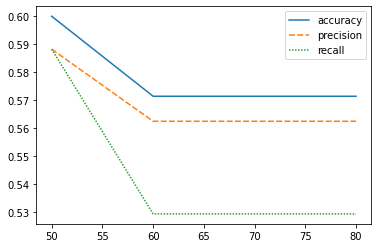

In [51]:
sns.lineplot(data=results);